In [1]:
#%pip install scipy==1.11.4

In [2]:
import pandas as pd
import numpy as np
import os
import pickle

from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import export_graphviz

from functions.missclassification_rate import missclassification_rate
from functions.extract_original_feature_name import extract_original

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data and model imports

In [4]:
path = os.getcwd() + '/data'
X_test = pd.read_csv(path + '/X_test.csv')
y_test = pd.read_csv(path + '/y_test.csv')
X_train = pd.read_csv(path + '/X_train.csv')
y_train = pd.read_csv(path + '/y_train.csv')

# Evaluation

## Initialization of lists for results table

In [5]:
model_name_result = ['Logistic Regression (undersample)', 'Logistic Regression (oversample)', 'Random forest (undersample)', 'Random forest (oversample)',
         'XGB (undersample)', 'XGB (oversample)', 'LGB (undersample)', 'LGB (oversample)']
recall_result = []
precision_result = []
f1_result = []
acc_result = []
ks_result = []
roc_auc_result = []
pr_auc_result = []
miss_rate_result = []
acc_diff_result = []
recall_diff_result = []
fn_cnt = []

## Logistic Regression

In [6]:
with open('models/under_lr.pkl', 'rb') as f:
    u_lr = pickle.load(f)
f.close()

with open('models/over_lr.pkl', 'rb') as f:
    o_lr = pickle.load(f)
f.close()

### Predictions

In [7]:
lr_under_y_pred = u_lr.predict(X_test)
lr_over_y_pred = o_lr.predict(X_test)

lr_under_y_pred_proba = u_lr.predict_proba(X_test)
lr_over_y_pred_proba =o_lr.predict_proba(X_test)

under_train_pred = u_lr.predict(X_train)
over_train_pred = o_lr.predict(X_train)
under_train_pred_proba = u_lr.predict_proba(X_train)
over_train_pred_proba = o_lr.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1] during transform. These unknown

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_12678/2786963175.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


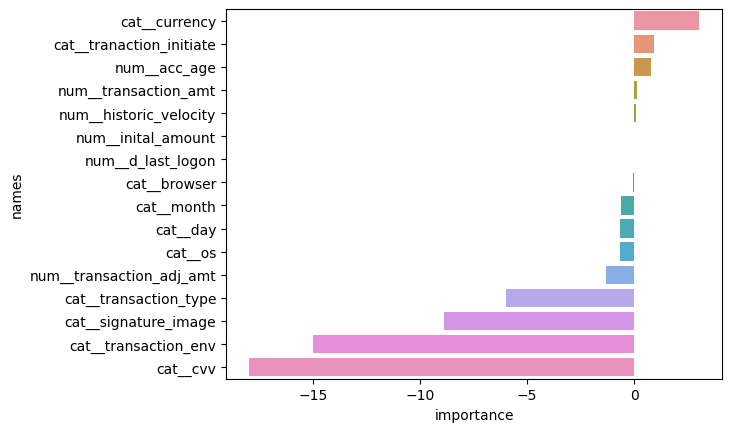

                       names  importance
1              cat__currency    3.036383
7   cat__tranaction_initiate    0.923700
10              num__acc_age    0.785269
15      num__transaction_amt    0.141596
12    num__historic_velocity    0.069259
13        num__inital_amount   -0.006064
11         num__d_last_logon   -0.020717
0               cat__browser   -0.074365
4                 cat__month   -0.624450
3                   cat__day   -0.682777
5                    cat__os   -0.688268
14  num__transaction_adj_amt   -1.325115
9      cat__transaction_type   -5.992006
6       cat__signature_image   -8.894449
8       cat__transaction_env  -15.010227
2                   cat__cvv  -17.997307


In [8]:
coef = list(u_lr.best_estimator_.named_steps['LogReg'].coef_)
f_names = list(u_lr.best_estimator_[:-1].get_feature_names_out())
imp_temp  = pd.DataFrame({'names': f_names, 'importance': coef[0]}).sort_values(by='importance', ascending=False)

cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_12678/1410451271.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


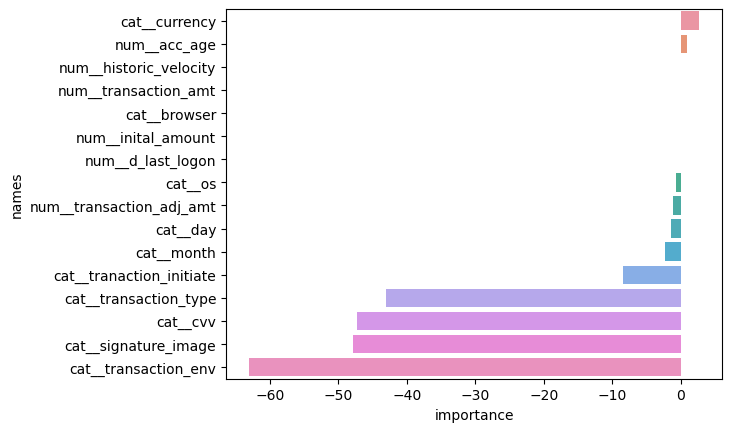

                       names  importance
1              cat__currency    2.725243
10              num__acc_age    0.973888
12    num__historic_velocity    0.094293
15      num__transaction_amt    0.091116
0               cat__browser    0.020777
13        num__inital_amount   -0.005969
11         num__d_last_logon   -0.015584
5                    cat__os   -0.695168
14  num__transaction_adj_amt   -1.177301
3                   cat__day   -1.463551
4                 cat__month   -2.262203
7   cat__tranaction_initiate   -8.441409
9      cat__transaction_type  -43.033764
2                   cat__cvv  -47.244854
6       cat__signature_image  -47.807519
8       cat__transaction_env  -63.111540


In [9]:
coef = list(o_lr.best_estimator_.named_steps['LogReg'].coef_)
f_names = list(o_lr.best_estimator_[:-1].get_feature_names_out())
imp_temp  = pd.DataFrame({'names': f_names, 'importance': coef[0]}).sort_values(by='importance', ascending=False)

cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [10]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}, loc: {ks.statistic_location}")
loc_under_lr = ks.statistic_location
ks_result.append(ks.statistic)

0.7708 p-value: 0.000e+00, loc: 0.5612250094354373


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


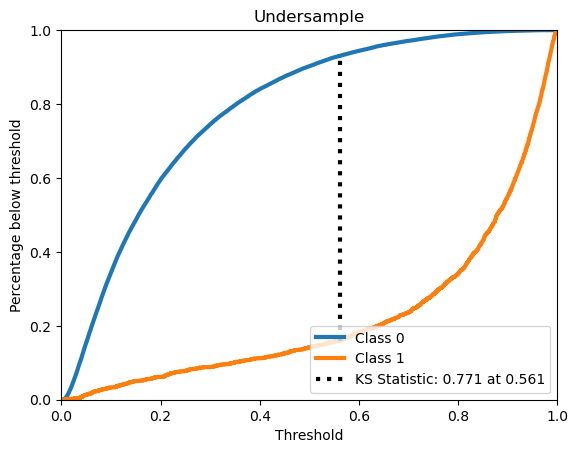

In [11]:
skplt.metrics.plot_ks_statistic(y_test, lr_under_y_pred_proba, title='Undersample')
plt.show()

In [12]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lr_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}")
loc_over_lr = ks.statistic_location
ks_result.append(ks.statistic)



0.7696 p-value: 0.000e+00


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


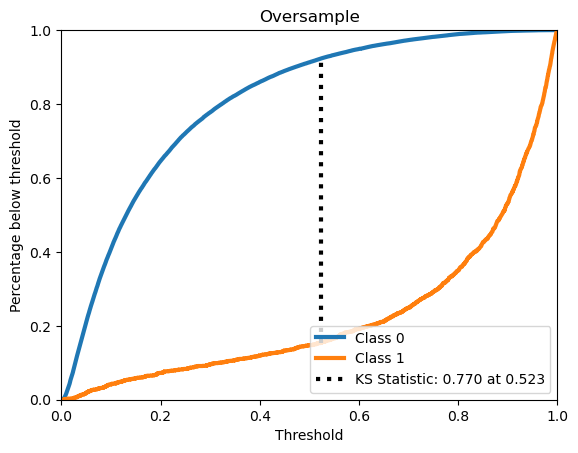

In [13]:
skplt.metrics.plot_ks_statistic(y_test, lr_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [14]:
lr_under_cut_off = loc_under_lr
lr_over_cut_off = loc_over_lr
lr_over_y_pred_proba_class = np.where(lr_over_y_pred_proba[:, 1] > lr_under_cut_off, 1, 0)
lr_under_y_pred_proba_class = np.where(lr_under_y_pred_proba[:, 1] > lr_over_cut_off, 1, 0)

### Precision-Recall Curve

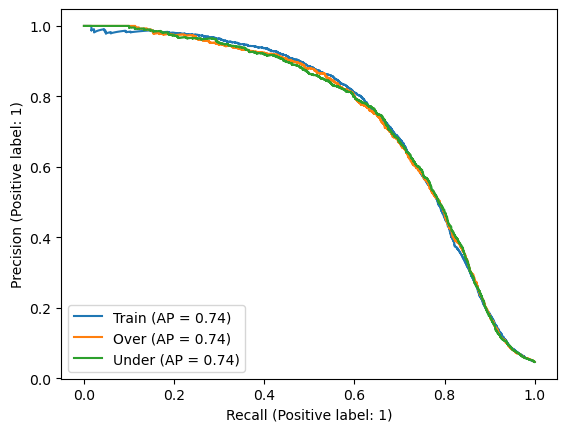

In [15]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

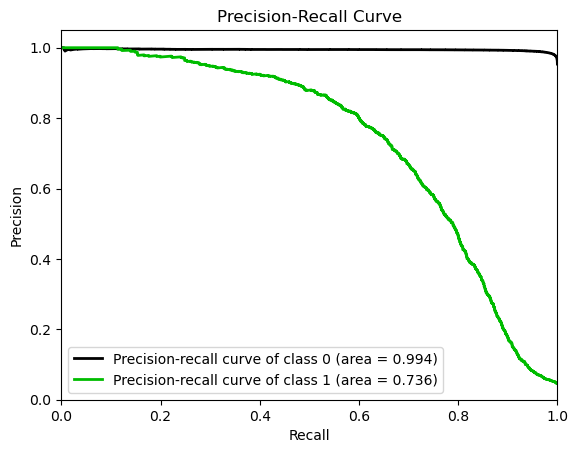

In [16]:
skplt.metrics.plot_precision_recall(y_test, lr_over_y_pred_proba, plot_micro=False)

### Confussion matrix

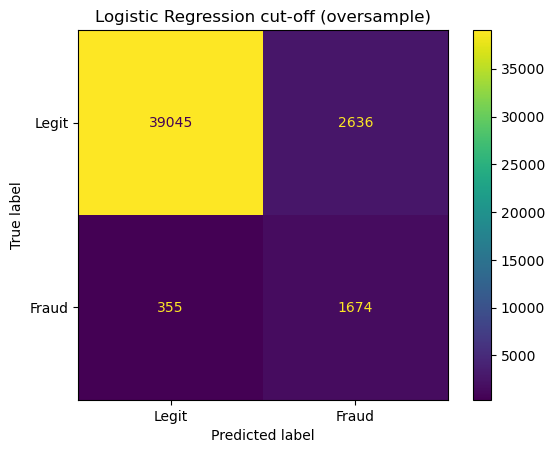

In [17]:
lr_cm_over = confusion_matrix(y_test, lr_over_y_pred_proba_class)
lr_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm_over, display_labels = ['Legit', 'Fraud'])
lr_cm_over_display.plot()
plt.title('Logistic Regression cut-off (oversample)')
plt.show()

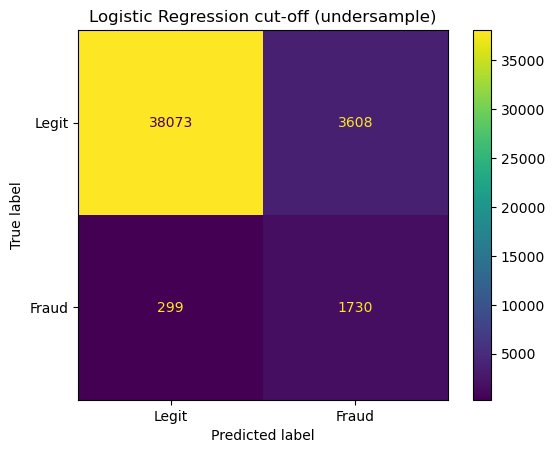

In [18]:
lr_cm_under = confusion_matrix(y_test, lr_under_y_pred_proba_class)
lr_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = lr_cm_under, display_labels = ['Legit', 'Fraud'])
lr_cm_under_display.plot()
plt.title('Logistic Regression cut-off (undersample)')
plt.show()

In [19]:
fn_cnt.append((lr_cm_under[1][0]))
fn_cnt.append((lr_cm_over[1][0]))

### Cumulative Gain

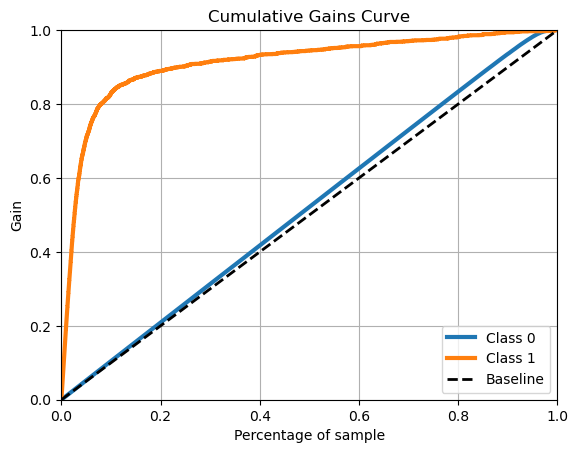

In [20]:
skplt.metrics.plot_cumulative_gain(y_test, lr_over_y_pred_proba)
plt.show()

### ROC

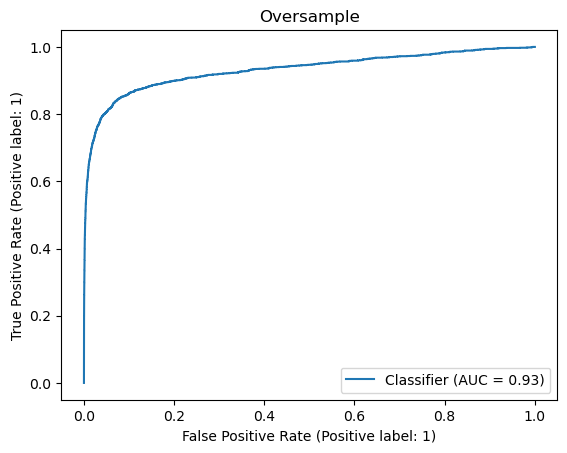

In [21]:
RocCurveDisplay.from_predictions(
    y_test, lr_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [22]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lr_over_y_pred_proba_class)}')

Accuracy Train: 0.9083911832764638 Test: 0.9315717227179136


In [23]:
print(classification_report(y_test, lr_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96     41681
           1       0.39      0.83      0.53      2029

    accuracy                           0.93     43710
   macro avg       0.69      0.88      0.75     43710
weighted avg       0.96      0.93      0.94     43710



In [24]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lr_over_y_pred)}')

The missclasification rate is: 0.08997940974605353


# Random Forest

In [25]:
with open('models/under_rf.pkl', 'rb') as f:
    u_rf = pickle.load(f)
f.close()

with open('models/over_rf.pkl', 'rb') as f:
    o_rf = pickle.load(f)
f.close()

### Predictions

In [26]:
rf_under_y_pred = u_rf.predict(X_test)
rf_over_y_pred = o_rf.predict(X_test)

rf_under_y_pred_proba = u_rf.predict_proba(X_test)
rf_over_y_pred_proba =o_rf.predict_proba(X_test)

under_train_pred = u_rf.predict(X_train)
over_train_pred = o_rf.predict(X_train)
under_train_pred_proba = u_rf.predict_proba(X_train)
over_train_pred_proba = o_rf.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_12678/167288925.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


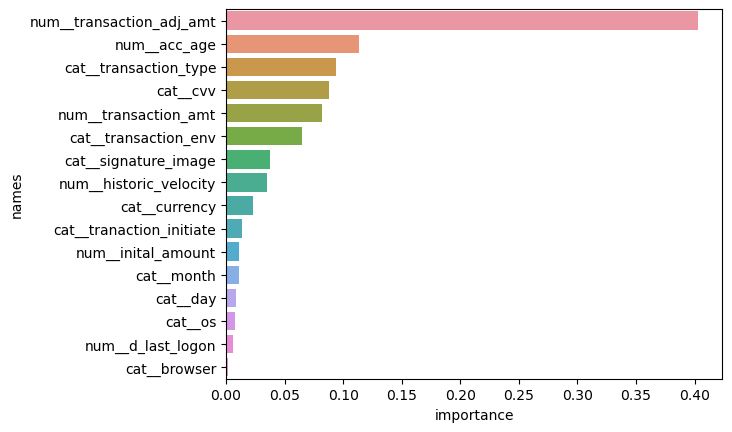

                       names  importance
14  num__transaction_adj_amt    0.403240
10              num__acc_age    0.113257
9      cat__transaction_type    0.093573
2                   cat__cvv    0.088122
15      num__transaction_amt    0.081981
8       cat__transaction_env    0.064783
6       cat__signature_image    0.037229
12    num__historic_velocity    0.035236
1              cat__currency    0.023447
7   cat__tranaction_initiate    0.013535
13        num__inital_amount    0.011361
4                 cat__month    0.010869
3                   cat__day    0.008378
5                    cat__os    0.007366
11         num__d_last_logon    0.005720
0               cat__browser    0.001906


In [27]:
importances = list(u_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(u_rf.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_12678/45559779.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


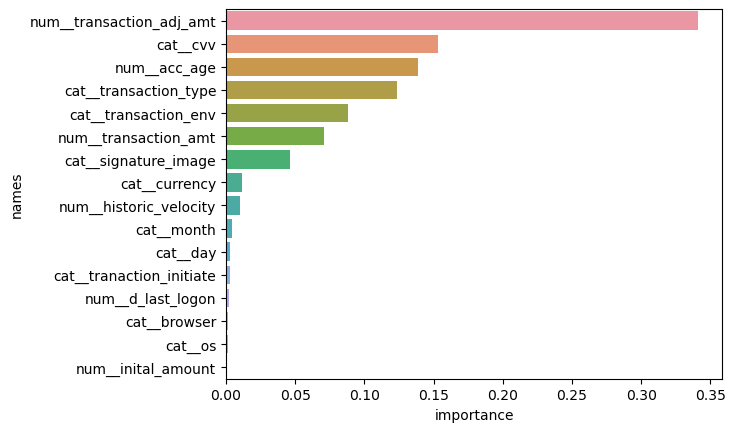

                       names  importance
14  num__transaction_adj_amt    0.341286
2                   cat__cvv    0.153480
10              num__acc_age    0.138895
9      cat__transaction_type    0.123427
8       cat__transaction_env    0.088483
15      num__transaction_amt    0.070919
6       cat__signature_image    0.046208
1              cat__currency    0.011532
12    num__historic_velocity    0.010328
4                 cat__month    0.004139
3                   cat__day    0.002924
7   cat__tranaction_initiate    0.002580
11         num__d_last_logon    0.002051
0               cat__browser    0.001729
5                    cat__os    0.001595
13        num__inital_amount    0.000424


In [28]:
importances = list(o_rf.best_estimator_.named_steps['RandomForest'].feature_importances_)
f_names = list(o_rf.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [29]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e}, loc: {ks.statistic_location}")
loc_under_rf = ks.statistic_location
ks_result.append(ks.statistic)

0.7812 p-value: 0.000e+00, loc: 0.5185371513585879


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


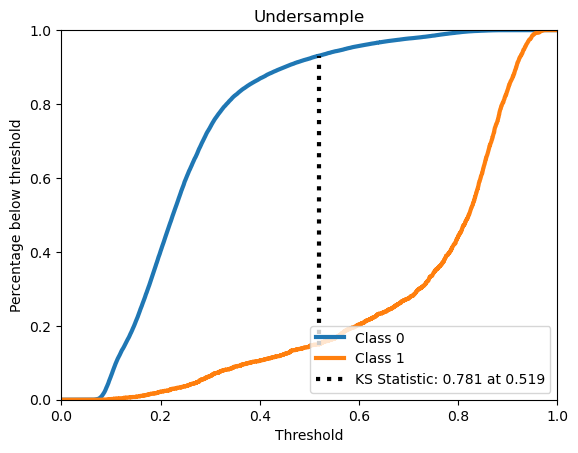

In [30]:
skplt.metrics.plot_ks_statistic(y_test, rf_under_y_pred_proba, title='Undersample')
plt.show()

In [31]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = rf_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_rf = ks.statistic_location
ks_result.append(ks.statistic)

0.7598 p-value: 0.000e+00 loc: 0.42063088326265297


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


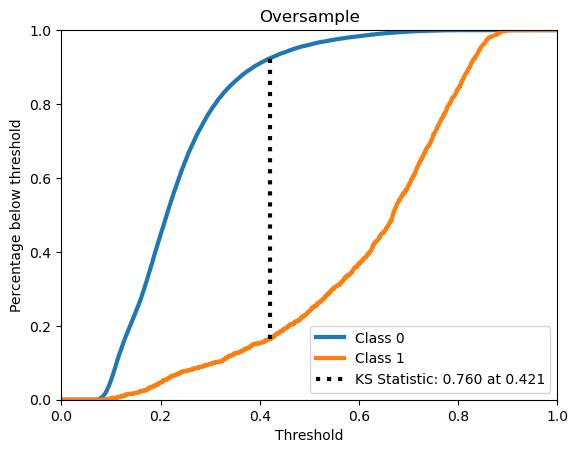

In [32]:
skplt.metrics.plot_ks_statistic(y_test, rf_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [33]:
rf_under_cut_off = loc_under_rf
rf_over_cut_off = loc_over_rf
rf_over_y_pred_proba_class = np.where(rf_over_y_pred_proba[:, 1] > rf_under_cut_off, 1, 0)
rf_under_y_pred_proba_class = np.where(rf_under_y_pred_proba[:, 1] > rf_over_cut_off, 1, 0)

### Precision-Recall Curve

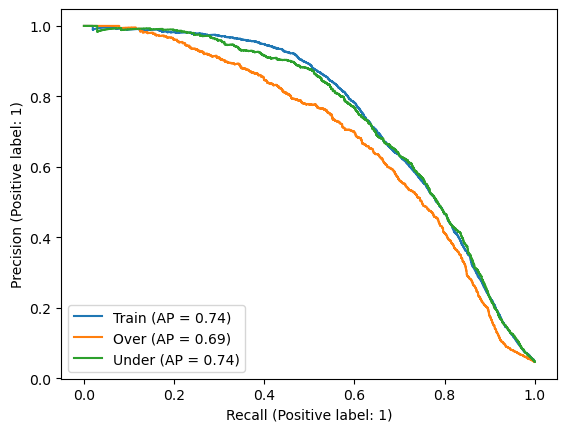

In [34]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

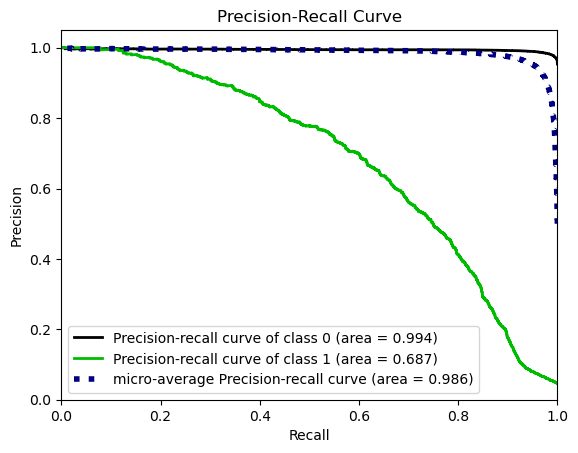

In [35]:
skplt.metrics.plot_precision_recall(y_test, rf_over_y_pred_proba)

### Confussion matrix

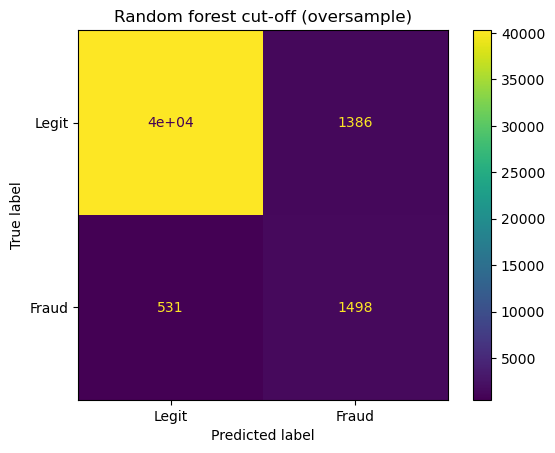

In [36]:
rf_cm_over = confusion_matrix(y_test, rf_over_y_pred_proba_class)
rf_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm_over, display_labels = ['Legit', 'Fraud'])
rf_cm_over_display.plot()
plt.title('Random forest cut-off (oversample)')
plt.show()

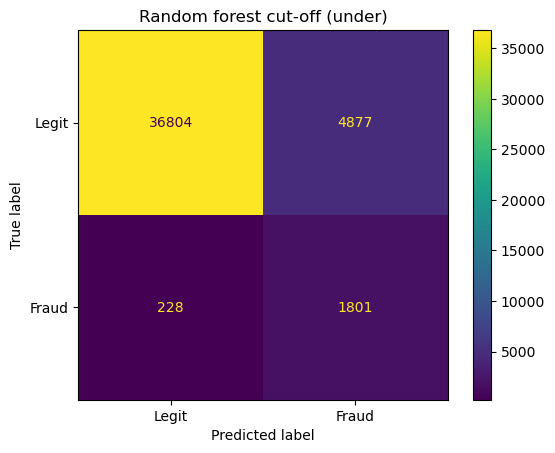

In [37]:
rf_cm_under = confusion_matrix(y_test, rf_under_y_pred_proba_class)
rf_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = rf_cm_under, display_labels = ['Legit', 'Fraud'])
rf_cm_under_display.plot()
plt.title('Random forest cut-off (under)')
plt.show()

In [38]:
fn_cnt.append((rf_cm_under[1][0]))
fn_cnt.append((rf_cm_over[1][0]))

### Cumulative Gain

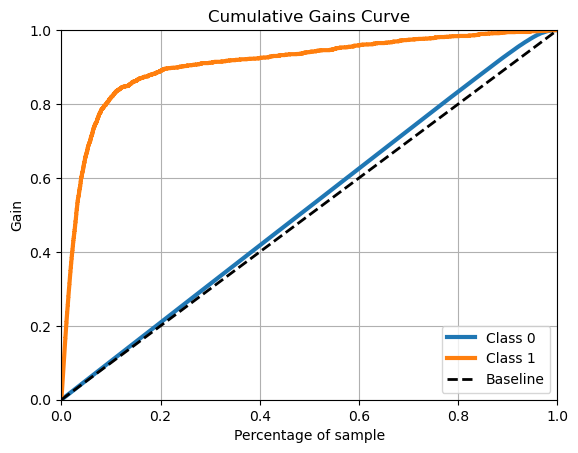

In [39]:
skplt.metrics.plot_cumulative_gain(y_test, rf_over_y_pred_proba)
plt.show()

### ROC

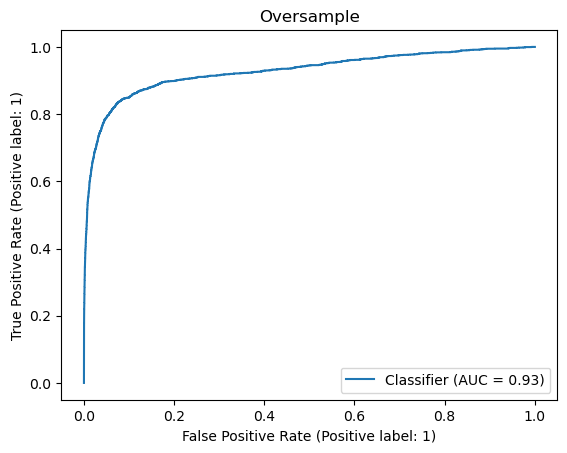

In [40]:
RocCurveDisplay.from_predictions(
    y_test, rf_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [41]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, rf_over_y_pred_proba_class)}')

Accuracy Train: 0.949905871278974 Test: 0.9561427590940288


In [42]:
print(classification_report(y_test, rf_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     41681
           1       0.52      0.74      0.61      2029

    accuracy                           0.96     43710
   macro avg       0.75      0.85      0.79     43710
weighted avg       0.97      0.96      0.96     43710



In [43]:
print(f'The missclasification rate is: {missclassification_rate(y_test, rf_over_y_pred)}')

The missclasification rate is: 0.048730267673301304


### Example of tree from random forest

In [44]:
features = u_rf.best_estimator_[1].transformers_[0][1].get_feature_names_out().tolist()
features.extend(u_rf.best_estimator_[1].transformers_[1][1].get_feature_names_out().tolist())
export_graphviz(u_rf.best_estimator_[2].estimators_[1], out_file='img/tree.dot',rounded=True, precision=2, proportion=False, filled=True,feature_names=features )

# XGBoosting

In [45]:
with open('models/under_xgb.pkl', 'rb') as f:
    u_xgb = pickle.load(f)
f.close()

with open('models/over_xgb.pkl', 'rb') as f:
    o_xgb = pickle.load(f)
f.close()

### Predictions

In [46]:
xgb_under_y_pred = u_xgb.predict(X_test)
xgb_over_y_pred = o_xgb.predict(X_test)

xgb_under_y_pred_proba = u_xgb.predict_proba(X_test)
xgb_over_y_pred_proba =o_xgb.predict_proba(X_test)

under_train_pred = u_xgb.predict(X_train)
over_train_pred = o_xgb.predict(X_train)
under_train_pred_proba = u_xgb.predict_proba(X_train)
over_train_pred_proba = o_xgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [3] during transform. These unknown categ

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_12678/1107856252.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


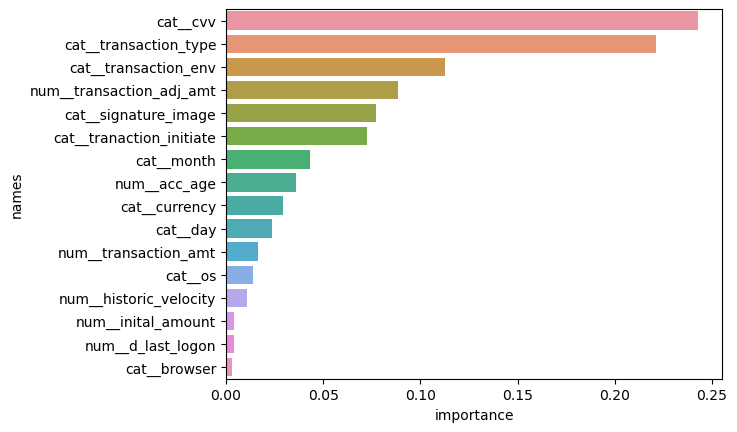

                       names  importance
2                   cat__cvv    0.243012
9      cat__transaction_type    0.221334
8       cat__transaction_env    0.112865
14  num__transaction_adj_amt    0.088314
6       cat__signature_image    0.077096
7   cat__tranaction_initiate    0.072657
4                 cat__month    0.043136
10              num__acc_age    0.035782
1              cat__currency    0.029527
3                   cat__day    0.023874
15      num__transaction_amt    0.016568
5                    cat__os    0.013761
12    num__historic_velocity    0.010658
13        num__inital_amount    0.004133
11         num__d_last_logon    0.003999
0               cat__browser    0.003285


In [47]:
importances = list(u_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(u_xgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_12678/1966249323.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


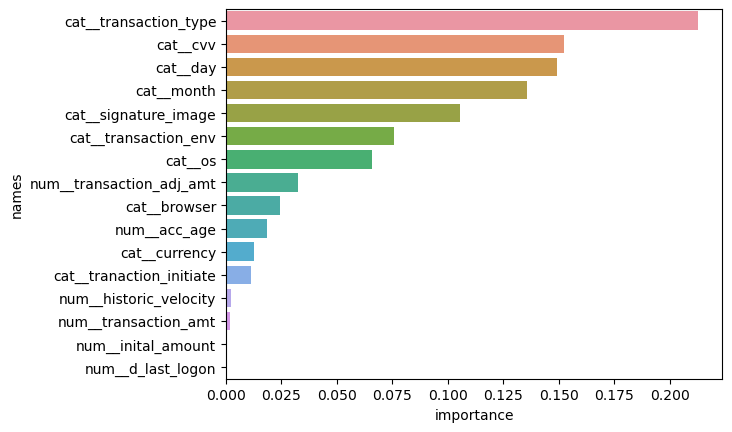

                       names  importance
9      cat__transaction_type    0.212897
2                   cat__cvv    0.152168
3                   cat__day    0.149063
4                 cat__month    0.135572
6       cat__signature_image    0.105322
8       cat__transaction_env    0.075601
5                    cat__os    0.065815
14  num__transaction_adj_amt    0.032283
0               cat__browser    0.024528
10              num__acc_age    0.018360
1              cat__currency    0.012683
7   cat__tranaction_initiate    0.011432
12    num__historic_velocity    0.002137
15      num__transaction_amt    0.001714
13        num__inital_amount    0.000221
11         num__d_last_logon    0.000203


In [48]:
importances = list(o_xgb.best_estimator_.named_steps['XGB'].feature_importances_)
f_names = list(o_xgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [49]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_under_xgb = ks.statistic_location
ks_result.append(ks.statistic)

0.7967 p-value: 0.000e+00 loc: 0.527281641960144


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


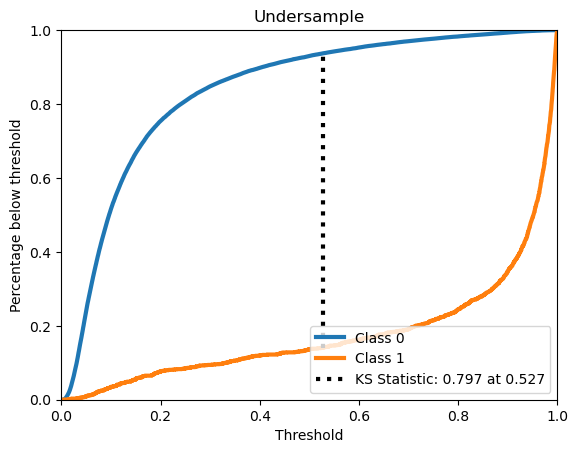

In [50]:
skplt.metrics.plot_ks_statistic(y_test, xgb_under_y_pred_proba, title='Undersample')
plt.show()

In [51]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = xgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_xgb = ks.statistic_location
ks_result.append(ks.statistic)

0.8116 p-value: 0.000e+00 loc: 0.061837077140808105


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


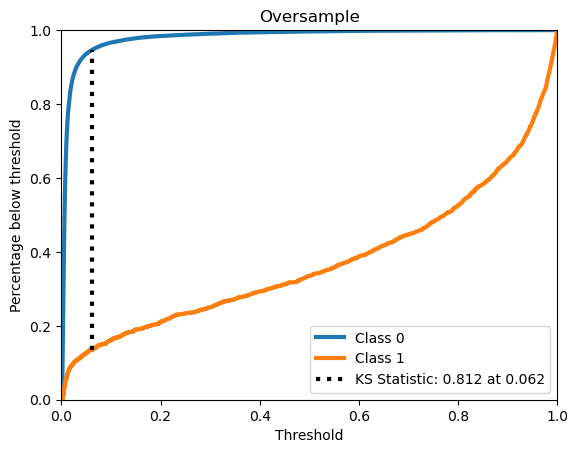

In [52]:
skplt.metrics.plot_ks_statistic(y_test, xgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [53]:
xgb_under_cut_off = loc_under_xgb
xgb_over_cut_off = loc_over_xgb
xgb_over_y_pred_proba_class = np.where(xgb_over_y_pred_proba[:, 1] > xgb_under_cut_off, 1, 0)
xgb_under_y_pred_proba_class = np.where(xgb_under_y_pred_proba[:, 1] > xgb_over_cut_off, 1, 0)

### Precision-Recall Curve

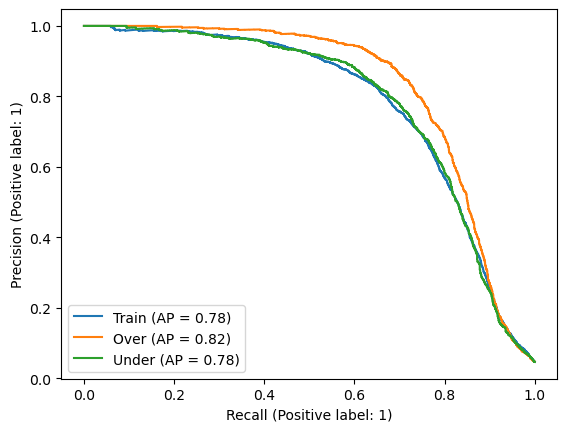

In [54]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

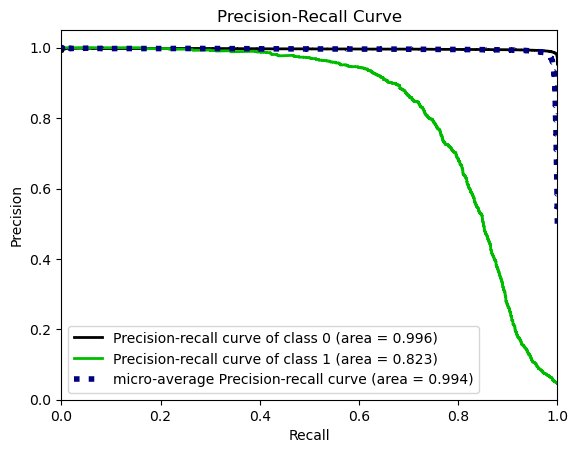

In [55]:
skplt.metrics.plot_precision_recall(y_test, xgb_over_y_pred_proba)

### Confussion matrix

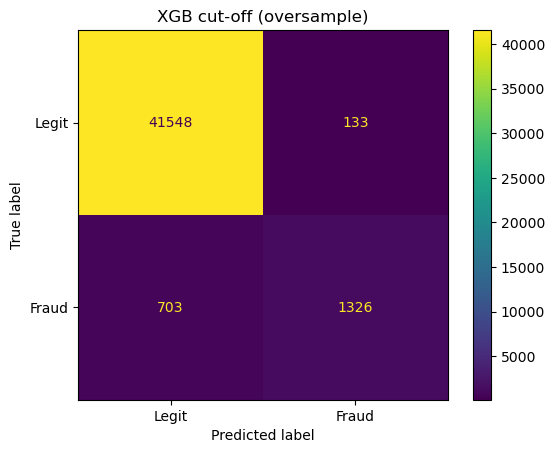

In [56]:
xgb_cm_over = confusion_matrix(y_test, xgb_over_y_pred_proba_class)
xgb_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm_over, display_labels = ['Legit', 'Fraud'])
xgb_cm_over_display.plot()
plt.title('XGB cut-off (oversample)')
plt.show()

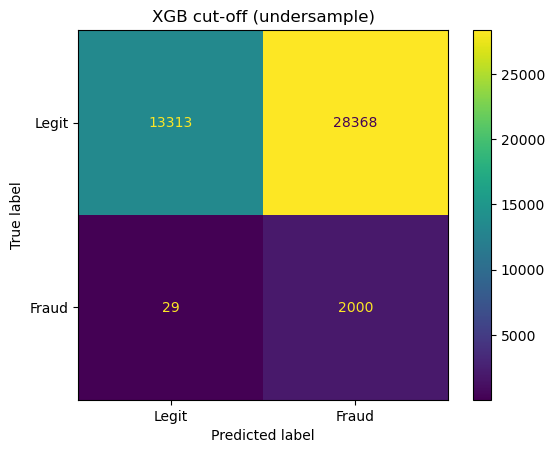

In [57]:
xgb_cm_under = confusion_matrix(y_test, xgb_under_y_pred_proba_class)
xgb_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = xgb_cm_under, display_labels = ['Legit', 'Fraud'])
xgb_cm_under_display.plot()
plt.title('XGB cut-off (undersample)')
plt.show()

In [58]:
fn_cnt.append((xgb_cm_under[1][0]))
fn_cnt.append((xgb_cm_over[1][0]))

### Cumulative Gain

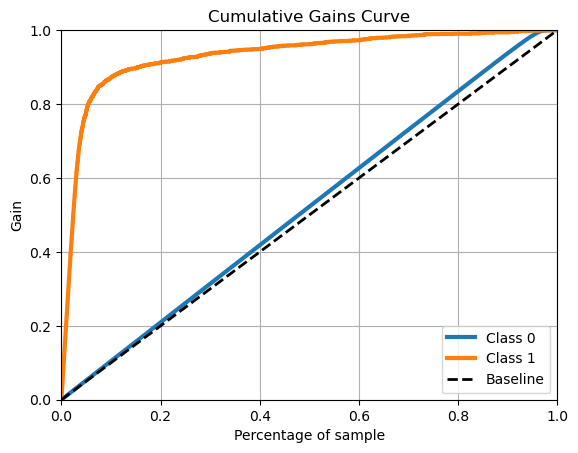

In [59]:
skplt.metrics.plot_cumulative_gain(y_test, xgb_over_y_pred_proba)
plt.show()

### ROC

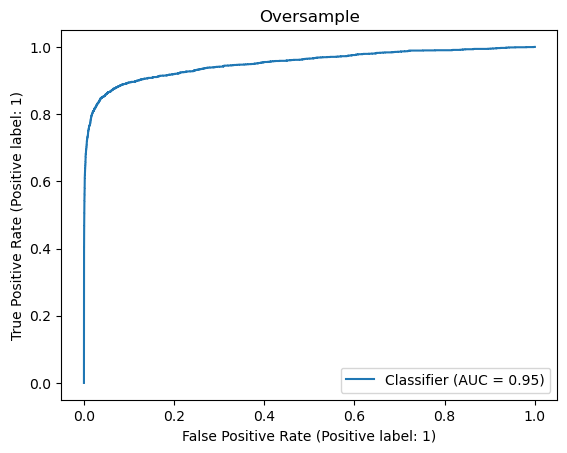

In [60]:
RocCurveDisplay.from_predictions(
    y_test, xgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [61]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, xgb_over_y_pred_proba_class)}')

Accuracy Train: 0.9807428324900969 Test: 0.9808739418897278


In [62]:
print(classification_report(y_test, xgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     41681
           1       0.91      0.65      0.76      2029

    accuracy                           0.98     43710
   macro avg       0.95      0.83      0.88     43710
weighted avg       0.98      0.98      0.98     43710



In [63]:
print(f'The missclasification rate is: {missclassification_rate(y_test, xgb_over_y_pred)}')

The missclasification rate is: 0.01896591169068863


# LGBoosting

In [64]:
with open('models/under_lgb.pkl', 'rb') as f:
    u_lgb = pickle.load(f)
f.close()

with open('models/over_lgb.pkl', 'rb') as f:
    o_lgb = pickle.load(f)
f.close()

### Predictions

In [65]:
lgb_under_y_pred = u_lgb.predict(X_test)
lgb_over_y_pred = o_lgb.predict(X_test)

lgb_under_y_pred_proba = u_lgb.predict_proba(X_test)
lgb_over_y_pred_proba =o_lgb.predict_proba(X_test)

under_train_pred = u_lgb.predict(X_train)
over_train_pred = o_lgb.predict(X_train)
under_train_pred_proba = u_lgb.predict_proba(X_train)
over_train_pred_proba = o_lgb.predict_proba(X_train)

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:227: UserWarning: Found unknown categories in columns [1, 2, 3, 4] during transform. T

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_12678/1819173728.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


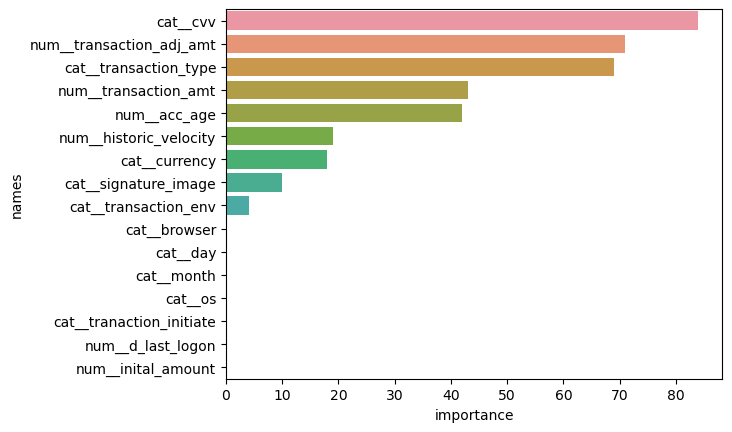

                       names  importance
2                   cat__cvv          84
14  num__transaction_adj_amt          71
9      cat__transaction_type          69
15      num__transaction_amt          43
10              num__acc_age          42
12    num__historic_velocity          19
1              cat__currency          18
6       cat__signature_image          10
8       cat__transaction_env           4
0               cat__browser           0
3                   cat__day           0
4                 cat__month           0
5                    cat__os           0
7   cat__tranaction_initiate           0
11         num__d_last_logon           0
13        num__inital_amount           0


In [66]:
importances = list(u_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(u_lgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

/var/folders/hy/zhb0tzc936dbsd1ct799_h8h0000gn/T/ipykernel_12678/3948416697.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))


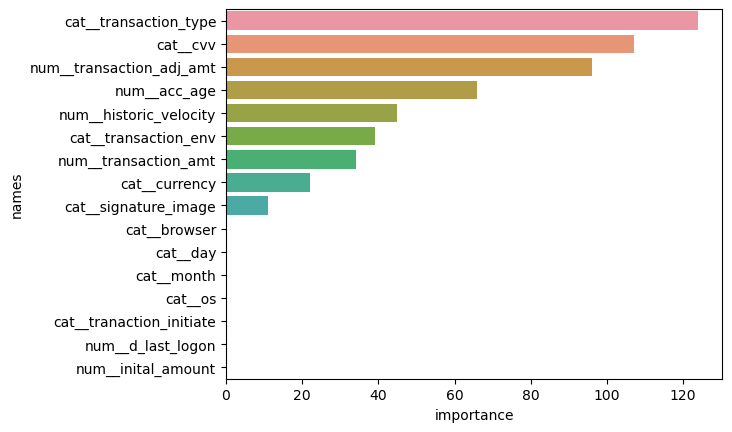

                       names  importance
9      cat__transaction_type         124
2                   cat__cvv         107
14  num__transaction_adj_amt          96
10              num__acc_age          66
12    num__historic_velocity          45
8       cat__transaction_env          39
15      num__transaction_amt          34
1              cat__currency          22
6       cat__signature_image          11
0               cat__browser           0
3                   cat__day           0
4                 cat__month           0
5                    cat__os           0
7   cat__tranaction_initiate           0
11         num__d_last_logon           0
13        num__inital_amount           0


In [67]:
importances = list(o_lgb.best_estimator_.named_steps['LGB'].feature_importances_)
f_names = list(o_lgb.best_estimator_[:-1].get_feature_names_out())
imp_temp = pd.DataFrame({'names': f_names, 'importance': importances}).sort_values(by='importance', ascending=False)
cat_select = imp_temp.loc[imp_temp['names'].str.startswith('cat')]
cat_select['names'] = cat_select['names'].apply(lambda x: extract_original(x))
num_select = imp_temp.loc[imp_temp['names'].str.startswith('num')]
imp_temp = pd.concat([num_select, cat_select])
imp_temp = imp_temp.groupby(by='names').sum().reset_index().sort_values(by='importance',ascending=False)
sns.barplot(x='importance', y='names', data=imp_temp)
plt.show()
print(imp_temp)

### Kologomorov-Smirnov 2-sample test

KS is robust to data unbalance.

In [68]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_under_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_under_lgb = ks.statistic_location
ks_result.append(ks.statistic)

0.7349 p-value: 0.000e+00 loc: 0.4881560481398791


Statystyka KS (D) - wynosi 0.747 przy treshholdzie 0.622 (threshold tzn. czyli przy takim prawdopodobieństwie obserwacja klasyfikowana jest jako fraud). \n
Jezeli przyjmiemy ze model ma przy tym prawdopodobieństwem dopiero przyjmowac to jako fraud (default 0.5) to wtedy najlepiej od siebie odseparowane sa klasy (legit i fraud). Maja tam najdalej od siebie polozone CDF (czyli dystrybuanty).

/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


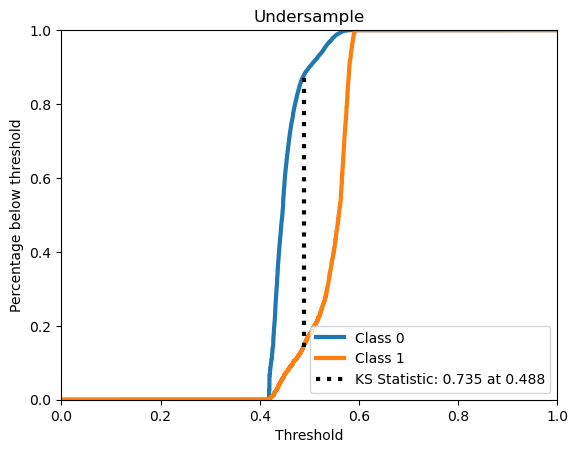

In [69]:
skplt.metrics.plot_ks_statistic(y_test, lgb_under_y_pred_proba, title='Undersample')
plt.show()

In [70]:
df = pd.DataFrame()
df['real'] = y_test
df['proba'] = lgb_over_y_pred_proba[:,1]

class0 = df[df['real'] == 0]
class1 = df[df['real'] == 1]
ks = ks_2samp(class0['proba'], class1['proba'])
print(f"{ks.statistic:.4f} p-value: {ks.pvalue:.3e} loc: {ks.statistic_location}")
loc_over_lgb = ks.statistic_location
ks_result.append(ks.statistic)

0.7667 p-value: 0.000e+00 loc: 0.39919092130152456


/Users/jakubkozlowski/anaconda3/envs/data_mining/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


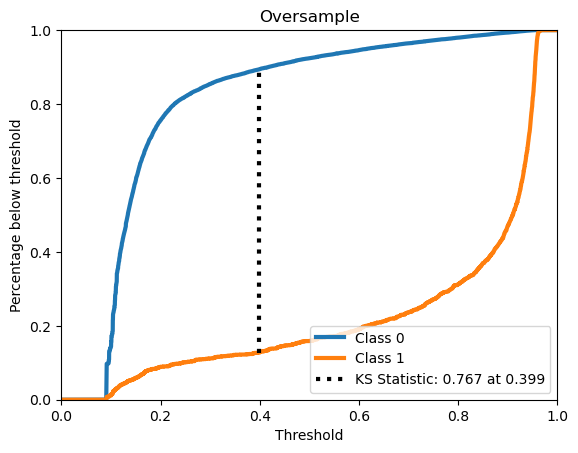

In [71]:
skplt.metrics.plot_ks_statistic(y_test, lgb_over_y_pred_proba, title='Oversample')
plt.show()

#### Cut-off

In [72]:
lgb_under_cut_off = loc_under_lgb
lgb_over_cut_off = loc_over_lgb
lgb_over_y_pred_proba_class = np.where(lgb_over_y_pred_proba[:, 1] > lgb_under_cut_off, 1, 0)
lgb_under_y_pred_proba_class = np.where(lgb_under_y_pred_proba[:, 1] > lgb_over_cut_off, 1, 0)

### Precision-Recall Curve

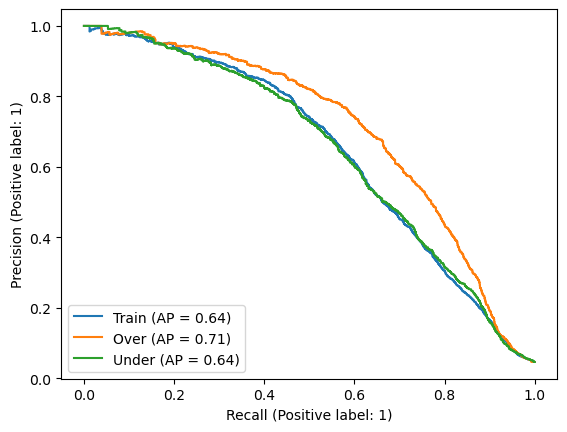

In [73]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_train, under_train_pred_proba[:, 1], ax=ax, name="Train")
PrecisionRecallDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name="Over")
PrecisionRecallDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name="Under")
plt.show()

<Axes: title={'center': 'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

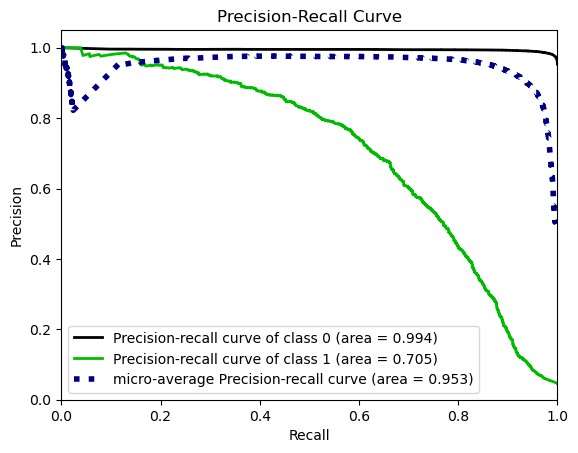

In [74]:
skplt.metrics.plot_precision_recall(y_test, lgb_over_y_pred_proba)

### Confussion matrix

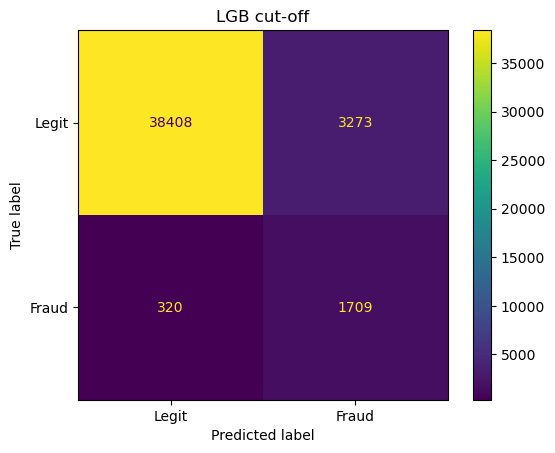

In [75]:
lgb_cm_over = confusion_matrix(y_test, lgb_over_y_pred_proba_class)
lgb_cm_over_display = ConfusionMatrixDisplay(confusion_matrix = lgb_cm_over, display_labels = ['Legit', 'Fraud'])
lgb_cm_over_display.plot()
plt.title('LGB cut-off')
plt.show()

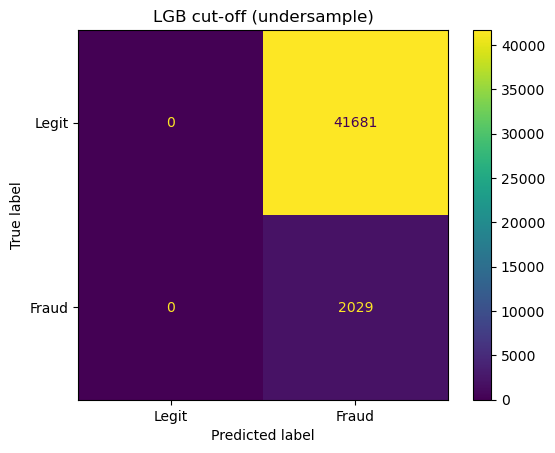

In [76]:
lgb_cm_under = confusion_matrix(y_test, lgb_under_y_pred_proba_class)
lgb_cm_under_display = ConfusionMatrixDisplay(confusion_matrix = lgb_cm_under, display_labels = ['Legit', 'Fraud'])
lgb_cm_under_display.plot()
plt.title('LGB cut-off (undersample)')
plt.show()

In [77]:
fn_cnt.append((lgb_cm_under[1][0]))
fn_cnt.append((lgb_cm_over[1][0]))

### Cumulative Gain

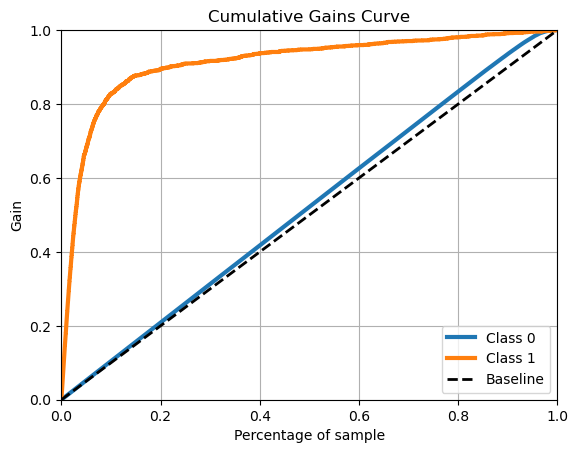

In [78]:
skplt.metrics.plot_cumulative_gain(y_test, lgb_over_y_pred_proba)
plt.show()

### ROC

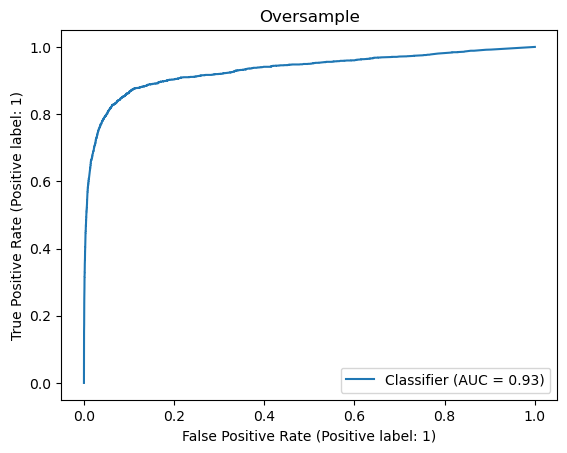

In [79]:
RocCurveDisplay.from_predictions(
    y_test, lgb_over_y_pred_proba[:, 1])
plt.title('Oversample')
plt.show()

### Stats

In [80]:
print(f'Accuracy Train: {accuracy_score(y_train, over_train_pred)} Test: {accuracy_score(y_test, lgb_over_y_pred_proba_class)}')

Accuracy Train: 0.9177844452288505 Test: 0.9177991306337223


In [81]:
print(classification_report(y_test, lgb_over_y_pred_proba_class))

              precision    recall  f1-score   support

           0       0.99      0.92      0.96     41681
           1       0.34      0.84      0.49      2029

    accuracy                           0.92     43710
   macro avg       0.67      0.88      0.72     43710
weighted avg       0.96      0.92      0.93     43710



In [82]:
print(f'The missclasification rate is: {missclassification_rate(y_test, lgb_over_y_pred)}')

The missclasification rate is: 0.07991306337222603


# Aggregated Results

In [83]:
# Logistic Regression
recall_result.append(recall_score(y_test, lr_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, lr_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, lr_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, lr_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, lr_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, lr_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, lr_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, lr_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, lr_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, lr_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, lr_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, lr_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, lr_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, lr_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, lr_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, lr_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, lr_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, lr_over_y_pred_proba_class)))

In [84]:
# Random Forest
recall_result.append(recall_score(y_test, rf_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, rf_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, rf_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, rf_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, rf_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, rf_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, rf_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, rf_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, rf_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, rf_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, rf_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, rf_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, rf_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, rf_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, rf_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, rf_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, rf_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, rf_over_y_pred_proba_class)))

In [85]:
# XGB
recall_result.append(recall_score(y_test, xgb_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, xgb_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, xgb_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, xgb_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, xgb_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, xgb_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, xgb_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, xgb_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, xgb_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, xgb_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, xgb_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, xgb_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, xgb_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, xgb_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, xgb_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, xgb_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, xgb_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, xgb_over_y_pred_proba_class)))

In [86]:
# LGB
recall_result.append(recall_score(y_test, lgb_under_y_pred_proba_class))
recall_result.append(recall_score(y_test, lgb_over_y_pred_proba_class))

precision_result.append(precision_score(y_test, lgb_under_y_pred_proba_class))
precision_result.append(precision_score(y_test, lgb_over_y_pred_proba_class))

f1_result.append(f1_score(y_test, lgb_under_y_pred_proba_class))
f1_result.append(f1_score(y_test, lgb_over_y_pred_proba_class))

acc_result.append(accuracy_score(y_test, lgb_under_y_pred_proba_class))
acc_result.append(accuracy_score(y_test, lgb_over_y_pred_proba_class))

miss_rate_result.append(missclassification_rate(y_test, lgb_under_y_pred_proba_class))
miss_rate_result.append(missclassification_rate(y_test, lgb_over_y_pred_proba_class))

roc_auc_result.append(roc_auc_score(y_test, lgb_under_y_pred_proba[:, 1]))
roc_auc_result.append(roc_auc_score(y_test, lgb_over_y_pred_proba[:, 1]))

pr_auc_result.append(average_precision_score(y_test, lgb_under_y_pred_proba[:, 1]))
pr_auc_result.append(average_precision_score(y_test, lgb_over_y_pred_proba[:, 1]))

acc_diff_result.append(np.abs(accuracy_score(y_train, under_train_pred) - accuracy_score(y_test, lgb_under_y_pred_proba_class)))
acc_diff_result.append(np.abs(accuracy_score(y_train, over_train_pred) - accuracy_score(y_test, lgb_over_y_pred_proba_class)))

recall_diff_result.append(np.abs(recall_score(y_train, under_train_pred) - recall_score(y_test, lgb_under_y_pred_proba_class)))
recall_diff_result.append(np.abs(recall_score(y_train, over_train_pred) - recall_score(y_test, lgb_over_y_pred_proba_class)))

In [87]:
wyniki = pd.DataFrame(
    {'Model': model_name_result,'Recall': recall_result, 'Precision':precision_result,'F1': f1_result,
    'Accuracy': acc_result, 'KS' : ks_result, 'ROC_AUC': roc_auc_result,'PR_AUC': pr_auc_result,
    'Missclassification_rate': miss_rate_result, 'Acc_diff': acc_diff_result,'Recall_diff': recall_diff_result, 'False_negatives': fn_cnt}
    )


In [92]:
wyniki.sort_values(by='False_negatives')

,Model,Recall,Precision,F1,Accuracy,KS,ROC_AUC,PR_AUC,Missclassification_rate,Acc_diff,Recall_diff,False_negatives
6,LGB (undersample),1.000000,0.046420,0.088721,0.046420,0.734874,0.920994,0.643577,0.953580,0.846038,0.180608,0
4,XGB (undersample),0.985707,0.065859,0.123468,0.350332,0.796654,0.948618,0.783518,0.649668,0.542126,0.166316,29
2,Random forest (undersample),0.887629,0.269692,0.413690,0.883208,0.781233,0.946753,0.736414,0.116792,0.009250,0.068238,228
0,Logistic Regression (undersample),0.852637,0.324091,0.469662,0.910615,0.770763,0.931476,0.736554,0.089385,0.018157,0.033245,299
7,LGB (oversample),0.842287,0.343035,0.487520,0.917799,0.766691,0.931518,0.705183,0.082201,0.000015,0.003673,320
1,Logistic Regression (oversample),0.825037,0.388399,0.528159,0.931572,0.769613,0.931504,0.736342,0.068428,0.013787,0.013577,355
3,Random forest (oversample),0.738295,0.519417,0.609811,0.956143,0.759850,0.927435,0.686566,0.043857,0.038358,0.100320,531
5,XGB (oversample),0.653524,0.908842,0.760321,0.980874,0.811624,0.951360,0.823239,0.019126,0.063089,0.185090,703


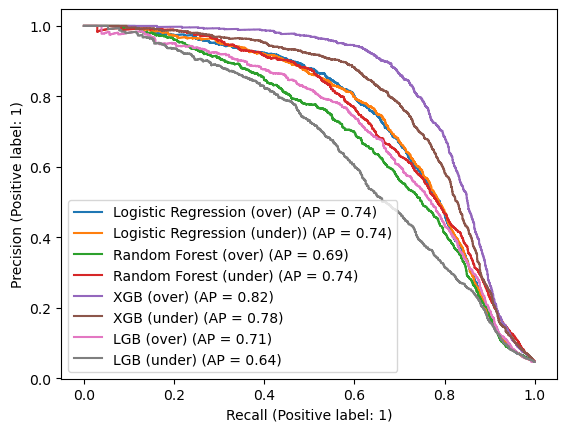

In [89]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name= "Logistic Regression (over)")
PrecisionRecallDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name="Logistic Regression (under))")

PrecisionRecallDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name= "Random Forest (over)")
PrecisionRecallDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name="Random Forest (under)")

PrecisionRecallDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name= "XGB (over)")
PrecisionRecallDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name="XGB (under)")

PrecisionRecallDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name= "LGB (over)")
PrecisionRecallDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name="LGB (under)")
plt.savefig("img/pr_result.png")
plt.show()

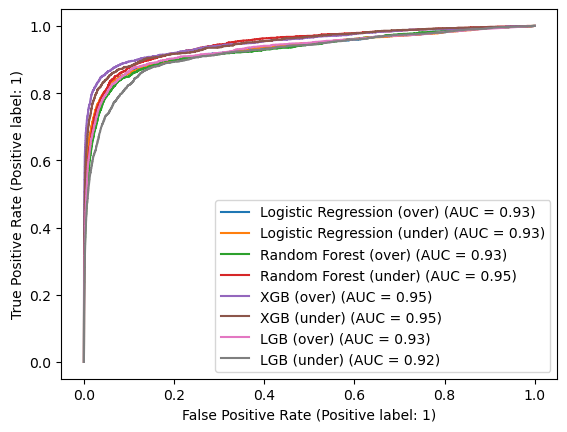

In [90]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, lr_over_y_pred_proba[:, 1], ax=ax, name= 'Logistic Regression (over)')
RocCurveDisplay.from_predictions(y_test, lr_under_y_pred_proba[:, 1], ax=ax, name='Logistic Regression (under)')

RocCurveDisplay.from_predictions(y_test, rf_over_y_pred_proba[:, 1], ax=ax, name= 'Random Forest (over)')
RocCurveDisplay.from_predictions(y_test, rf_under_y_pred_proba[:, 1], ax=ax, name='Random Forest (under)')

RocCurveDisplay.from_predictions(y_test, xgb_over_y_pred_proba[:, 1], ax=ax, name= 'XGB (over)')
RocCurveDisplay.from_predictions(y_test, xgb_under_y_pred_proba[:, 1], ax=ax, name='XGB (under)')

RocCurveDisplay.from_predictions(y_test, lgb_over_y_pred_proba[:, 1], ax=ax, name= 'LGB (over)')
RocCurveDisplay.from_predictions(y_test, lgb_under_y_pred_proba[:, 1], ax=ax, name='LGB (under)')
plt.show()

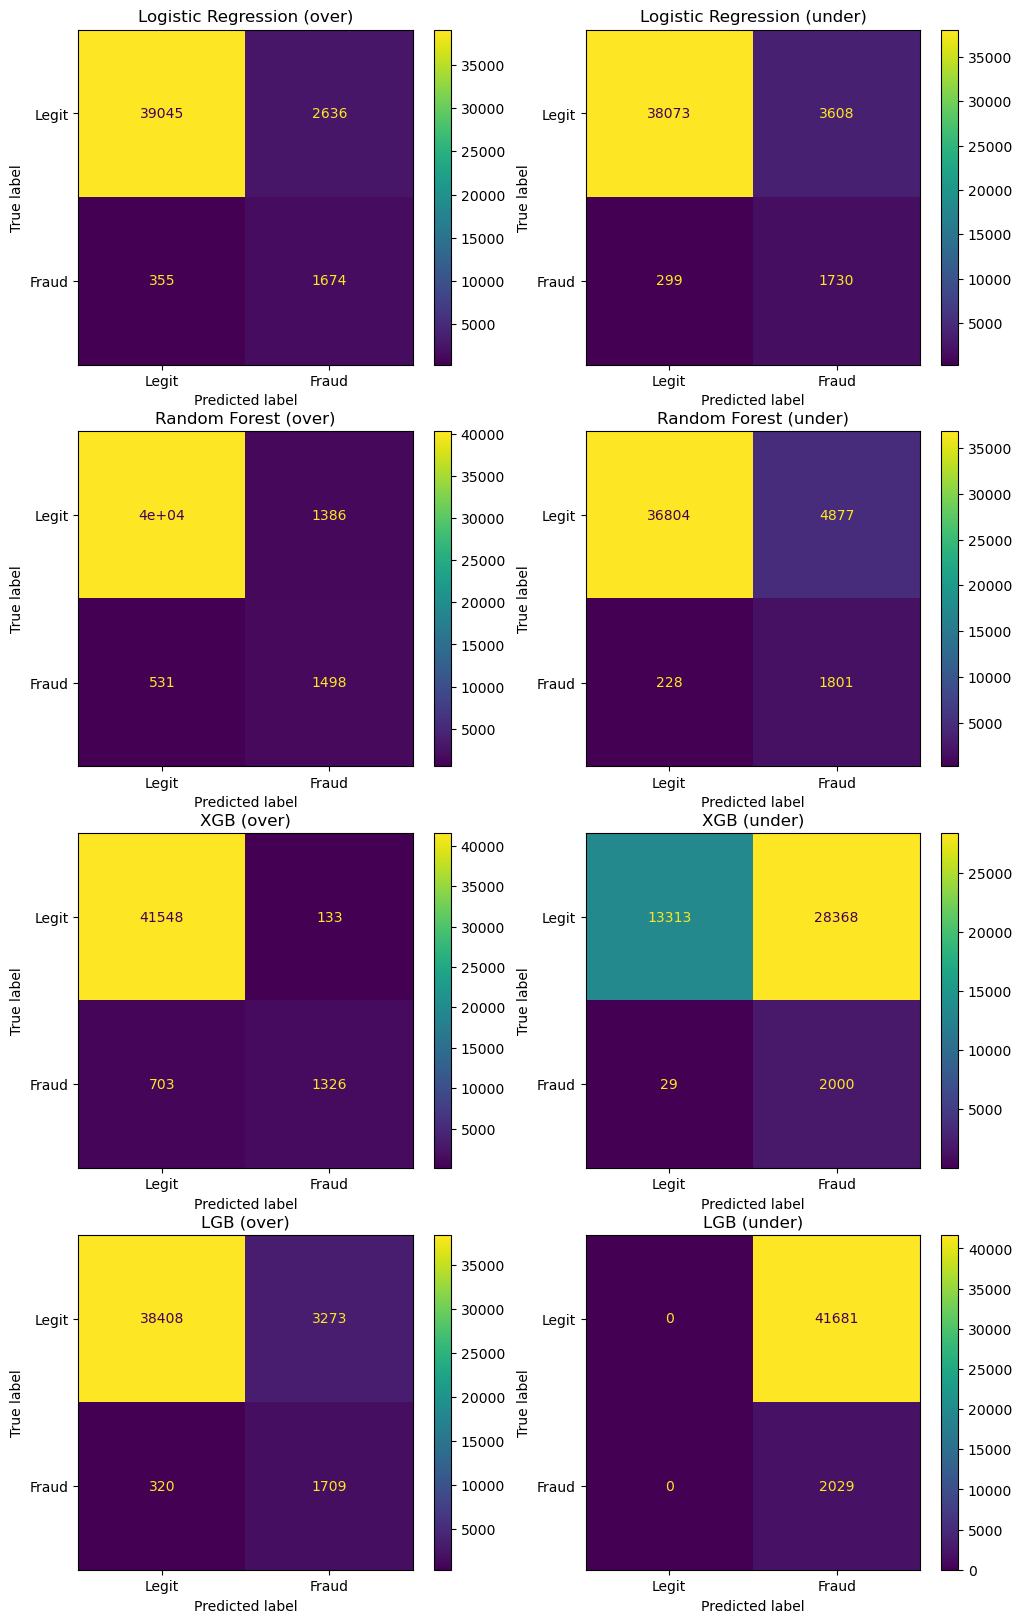

In [91]:
fig, axs = plt.subplots(4, 2, figsize=(12, 20))
lr_cm_over_display.plot(ax=axs[0][0])
axs[0][0].set_title('Logistic Regression (over)')
rf_cm_over_display.plot(ax=axs[1][0])
axs[1][0].set_title('Random Forest (over)')
xgb_cm_over_display.plot(ax=axs[2][0])
axs[2][0].set_title('XGB (over)')
lgb_cm_over_display.plot(ax=axs[3][0])
axs[3][0].set_title('LGB (over)')
lr_cm_under_display.plot(ax=axs[0][1])
axs[0][1].set_title('Logistic Regression (under)')
rf_cm_under_display.plot(ax=axs[1][1])
axs[1][1].set_title('Random Forest (under)')
xgb_cm_under_display.plot(ax=axs[2][1])
axs[2][1].set_title('XGB (under)')
lgb_cm_under_display.plot(ax=axs[3][1])
axs[3][1].set_title('LGB (under)')
plt.show()